**ML-FINAL PROJECT: SPAM ARTICLE DETECTION**

$\textbf{AUTHORS}$: Everett Kirkpatrick, Yair Ben-Naim, Muntaha Pasha, Erik Pohle, Nick Julander

**IMPORTS USED:**

There are all the imports that we included in our file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D, Bidirectional

**READ IN THE TEST AND TRAINING DATA:**

Here we read in the training and testing set.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

**PLOTTING FAKE/REAL NEWS:**

We wanted to see the distribution of the training data, and how many articles are fake versus how many are real.

Text(0, 0.5, 'Proportion of News Articles')

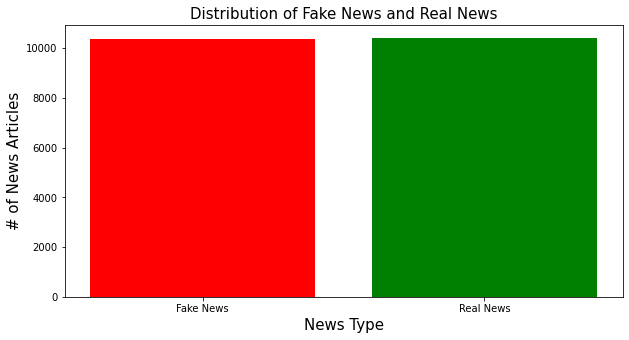

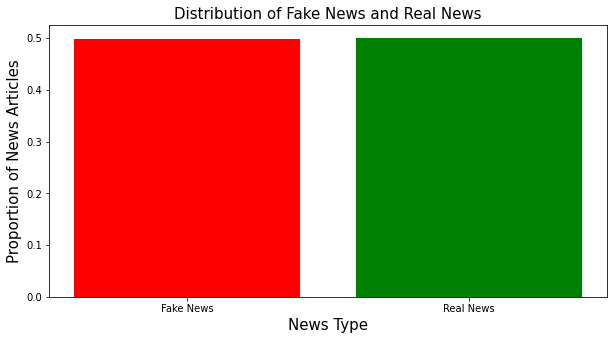

In [3]:
real = []
fake = []
for i in train['label'].values:
    if i == 0:
        fake.append(i)
    else:
        real.append(i)
        
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake), color='red')
plt.bar('Real News', len(real), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake) + len(real)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake) / total_len, color='red')
plt.bar('Real News', len(real) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

**SETTING UP TOKENIZER AND FILTER:**
    
Here we are creating our filters and setting up the tokenizer.

In [4]:
# drop the id column since the first column is the index anyways
train = train.set_index('id', drop = True)

# set the max_features to 1500 because my of computation limitations
max_features = 1500

# some of the title and author values are not none so classify them as missing instead of null
train[['title', 'author']] = train[['title', 'author']].fillna(value = 'Missing')

# drop any other value that is null, this will only be rows where the text itself is null, so these values are not needed
train = train.dropna()
train.isnull().sum()

# count the length of each article by character and append that as a new column
length = []
[length.append(len(str(text))) for text in train['text']]
train['length'] = length

# the articles where the length is less than 50 is mostly nonsense
# drop those articles
train = train.drop(train['text'][train['length'] < 50].index, axis = 0)
y = train['label'].values

# tokenizer for the text
# num_words is the maximum number of words in the tokenizer, if an article has more than this number of unique words than it drops the ones that haven't yet been seen

# the oov_token tells the tokenizer what to do when it encounters a word that it hasn't seen before
# this is useful in testing after the model has been trained, in a test article it will change the
# word it hasn't seen befor to <00V> and then encode it, this will keep the length of the article 
# so it doesn't lose too much meaning

# lower converts all the words to lowercase, splits the words by space

# fit_on_texts looks at all the words in the dataset and uses that as the vocab to tokenize

#texts_to_sequences transforms the list of text to an encoding of each word that appears 
#(Example) text = [1, 3, 4, 2], internal structure of tekenizer contains a dictionary
#dictionary:
# word_index = {
# 'hello' : 1,
# 'you' : 2,
# 'how' : 3,
# 'are' : 4
#}

tokenizer = Tokenizer(num_words = max_features, 
                    filters='!""-#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                    lower = True, 
                    split = ' ',
                    oov_token='<00V>')

# if using a computer with more resources, then use this tokenizer
'''
tokenizer = Tokenizer(num_words = None, 
                   filters='!""-#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                    lower = True, 
                    split = ' ',
                    oov_token='<00V>')
                    '''

'\ntokenizer = Tokenizer(num_words = None, \n                   filters=\'!""-#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\', \n                    lower = True, \n                    split = \' \',\n                    oov_token=\'<00V>\')\n                    '

**DATA OBSERVATIONS:**

Checking different features between real and fake, such as punctuation.

In [1]:
exc_true = sum(train['text'][train['label']==0].str.count('!'))/len(train['label']==0)
exc_fake = sum(train['text'][train['label']==1].str.count('!'))/len(train['label']==1)
print("Mean ! in True Article: ", exc_true)
print("Mean ! in Fake Article: ", exc_fake)

ques_true = sum(train['text'][train['label']==0].str.count('.'))/len(train['label']==0)
ques_fake = sum(train['text'][train['label']==1].str.count('.'))/len(train['label']==1)
print("Mean . in True Article: ", ques_true)
print("Mean . in Fake Article: ", ques_fake)

NameError: name 'train' is not defined

In [5]:
tokenizer.fit_on_texts(texts = train['text'])
X = tokenizer.texts_to_sequences(texts = train['text'])

In [6]:
# padding the sequence, fills all articles with zeros at the beginning of the article to fit the length
# of the largest sequence of words in the dataset
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

# if using a computer with more resources, then use this padding
'''
X = pad_sequences(sequences = X, maxlen = None, padding = 'pre')
'''

"\nX = pad_sequences(sequences = X, maxlen = None, padding = 'pre')\n"

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**TRAINING THE MODEL ON THE DATASET:**

Here we finally add different layers and train the model using LSTM NN Model.

**SOURCES USED:**

1 - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

2 - https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy

3 - https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/

In [8]:
# ahhhh the good stuff
# the input layer is the max num features, which is the number of words in the article with
# the most number of words

# ideally embedding will group similar articles together

# then the first LSTM layer, the recurrent_dropout is the fraction of nodes around specific nodes to input
# into this node

# followed by a dropout layer, this randomly sets random nodes to a weight of zero, its meant to prevent
# overfitting and somewhat more closely mimics how the brain learns 
# (certain neurons learn specific things over time and other neurons "dropout" or rewire if they are not
# involved in a certain process)

# then a dense layer with no dropout

# then another dropout

# final dense layer that is the output of the model, 0 for fake 1 for real
lstm_model = Sequential(name = 'LSTM_NN_Model')
lstm_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = 'Embed_Layer'))
lstm_model.add(layer = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10), name = 'Bidirectional_Layer'))
lstm_model.add(layer = LSTM(units = 120, dropout = 0.2, recurrent_dropout = 0.2, name = 'LSTM_Layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = 'Dropout_Layer1'))
lstm_model.add(layer = Dense(units = 120,  activation = 'relu', name = 'Dense_Layer1'))
lstm_model.add(layer = Dropout(rate = 0.5, name = 'Dropout_Layer2'))
lstm_model.add(layer = Dense(units = len(set(y)),  activation = 'sigmoid', name = 'Dense_Layer2'))

# compiling the model
# loss is objective function
#"The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications 
#in computer vision and natural language processing."
#Using a different type of Cross Entropy, we could try sparse_categorical, or binary. Probably best to use binary.
lstm_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

**LSTM RESULTS:**

Here we check and see our accuracy and loss.

In [ ]:
# WARNING training the model on my computer took half an hour to run the first time
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 1)

 47/514 [=>............................] - ETA: 21:21 - loss: 0.6616 - accuracy: 0.5944

**SUMMARY:**

The first thing we did was analyze our data and see how much of it was training and how much of it was testing. Because we got our dataset from Kaggle, it was already nicely seperated into training and testing data. After reading those in, we tried to look into the kind of data we had, how much of it was real, how much of it was fake, and what the real and fake articles looked like; respectively. We also looked for different patterns such as punctuation marks between real articles and fake articles (surprisingly or not surprisingly, fake articles have a LOT more exclamation marks!). 

We then started to create our filter and tokenizer components to try and get the training set more manageable before we ran our data model on it. After creating the filters, we used an LSTM (Long-Short Term Model) to run against the data and added various different layers for it to try and test the accuracy. We played around with different features like adding more/less dropout layers, trying different cross entropy, and running on different numbers of epochs.